In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
BASE_DIR = 'UTKFace/'
# Reading all the images present in Base_Dir
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [3]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels

In [4]:
gender_dict = {0:'Male', 1:'Female'}
df = df.astype({'age':'float32', 'gender': 'int32'})
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.85, random_state=42)

In [5]:
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import utils
from keras.preprocessing import image
x_train = []
for file in train.image:
    img = keras.utils.load_img(""+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

In [6]:
x_train.shape
x_train = x_train/255
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [7]:
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
input_size = (128,128,1)
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [8]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])
history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=10, validation_split= 0.1)

Epoch 1/10
320/320 [==============================] - 217s 655ms/step - loss: 16.7963 - gender_output_loss: 0.6776 - age_output_loss: 16.1188 - gender_output_accuracy: 0.6578 - age_output_accuracy: 0.0484 - val_loss: 26.1215 - val_gender_output_loss: 0.5976 - val_age_output_loss: 25.5239 - val_gender_output_accuracy: 0.7809 - val_age_output_accuracy: 0.0562
Epoch 2/10
320/320 [==============================] - 197s 614ms/step - loss: 12.9054 - gender_output_loss: 0.5121 - age_output_loss: 12.3933 - gender_output_accuracy: 0.7559 - age_output_accuracy: 0.0247 - val_loss: 13.8784 - val_gender_output_loss: 0.5170 - val_age_output_loss: 13.3614 - val_gender_output_accuracy: 0.7893 - val_age_output_accuracy: 0.0337
Epoch 3/10
320/320 [==============================] - 192s 601ms/step - loss: 11.2964 - gender_output_loss: 0.4434 - age_output_loss: 10.8529 - gender_output_accuracy: 0.7972 - age_output_accuracy: 0.0113 - val_loss: 11.3588 - val_gender_output_loss: 0.4012 - val_age_output_loss:

In [9]:
val_gen_acc = np.mean(history.history['val_gender_output_accuracy']) 
print("%s: %.2f%%" % ('Gender Accuracy: ',(val_gen_acc*100)))
val_age_acc = np.mean(history.history['val_age_output_accuracy']) 
print("%s: %.2f%%" % ('Age Accuracy: ',(val_age_acc*100)))

Gender Accuracy: : 82.67%
Age Accuracy: : 1.71%


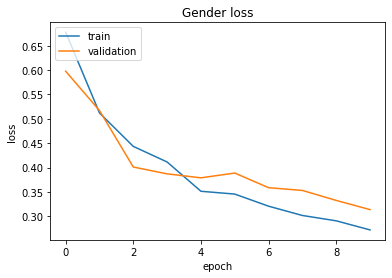

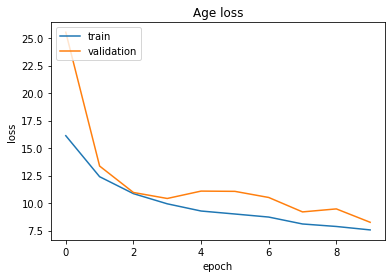

In [10]:
# Plotting the Gender Losses
plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plotting the Age Losses
plt.plot(history.history['age_output_loss'])
plt.plot(history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()